In [1]:
with_alazar = True


def get_pulse():
    from qctoolkit.pulses import TablePulseTemplate as TPT, SequencePulseTemplate as SPT, \
        RepetitionPulseTemplate as RPT, FunctionPulseTemplate as FPT, MultiChannelPulseTemplate as MPT

    sine = FPT('U*sin(2*pi*t/tau)', 'tau', channel='out')
    marker_on = FPT('1', 'tau', channel='trigger')

    multi = MPT([sine, marker_on], {'tau', 'U'})
    multi.atomicity = True

    assert sine.defined_channels == {'out'}
    assert multi.defined_channels == {'out', 'trigger'}

    sine.add_measurement_declaration('meas', 0, 'tau')

    base = SPT([(multi, dict(tau='tau', U='U'), dict(meas='A')),
                (multi, dict(tau='tau', U='U'), dict(meas='A')),
                (multi, dict(tau='tau', U='U'), dict(meas='A'))], {'tau', 'U'})

    repeated = RPT(base, 'n')

    root = SPT([repeated, repeated, repeated], {'tau', 'n', 'U'})

    assert root.defined_channels == {'out', 'trigger'}

    return root


def get_alazar_config():
    from atsaverage import alazar
    from atsaverage.config import ScanlineConfiguration, CaptureClockConfiguration, EngineTriggerConfiguration,\
        TRIGInputConfiguration, InputConfiguration
        
    r = 2.5
    rid = alazar.TriggerRangeID.etr_2V5

    trig_level = int((r + 0.05) / (2*r) * 255)
    assert 0 <= trig_level < 256

    config = ScanlineConfiguration()
    config.triggerInputConfiguration = TRIGInputConfiguration(triggerRange=rid)
    config.triggerConfiguration = EngineTriggerConfiguration(triggerOperation=alazar.TriggerOperation.J,
                                                             triggerEngine1=alazar.TriggerEngine.J,
                                                             triggerSource1=alazar.TriggerSource.external,
                                                             triggerSlope1=alazar.TriggerSlope.positive,
                                                             triggerLevel1=trig_level,
                                                             triggerEngine2=alazar.TriggerEngine.K,
                                                             triggerSource2=alazar.TriggerSource.disable,
                                                             triggerSlope2=alazar.TriggerSlope.positive,
                                                             triggerLevel2=trig_level)
    config.captureClockConfiguration = CaptureClockConfiguration(source=alazar.CaptureClockType.internal_clock,
                                                                 samplerate=alazar.SampleRateID.rate_100MSPS)
    config.inputConfiguration = 4*[InputConfiguration(input_range=alazar.InputRangeID.range_1_V)]
    config.totalRecordSize = 0
    config.aimedBufferSize = 10*config.aimedBufferSize

    assert config.totalRecordSize == 0

    return config


def get_operations():
    from atsaverage.operations import Downsample, RepAverage

    return [RepAverage(identifier='REP_A', maskID='A'),
           Downsample(identifier='raw', maskID='D')]


def get_window(card):
    from atsaverage.gui import ThreadedStatusWindow
    window = ThreadedStatusWindow(card)
    window.start()
    return window


def exec_test():
    import time
    import numpy as np

    t = []
    names = []

    def tic(name):
        t.append(time.time())
        names.append(name)

    from qctoolkit.hardware.awgs.tabor import TaborChannelPair, TaborAWGRepresentation
    tawg = TaborAWGRepresentation(r'USB0::0x168C::0x2184::0000216488::INSTR', reset=True)

    tchannelpair = TaborChannelPair(tawg, (1, 2), 'TABOR_AB')
    tawg.paranoia_level = 2

    # warnings.simplefilter('error', Warning)

    from qctoolkit.hardware.setup import HardwareSetup, PlaybackChannel, MarkerChannel
    hardware_setup = HardwareSetup()

    hardware_setup.set_channel('TABOR_A', PlaybackChannel(tchannelpair, 0))
    hardware_setup.set_channel('TABOR_B', PlaybackChannel(tchannelpair, 1))
    hardware_setup.set_channel('TABOR_A_MARKER', MarkerChannel(tchannelpair, 0))
    hardware_setup.set_channel('TABOR_B_MARKER', MarkerChannel(tchannelpair, 1))

    if with_alazar:
        from qctoolkit.hardware.dacs.alazar import AlazarCard
        import atsaverage.server

        if not atsaverage.server.Server.default_instance.running:
            atsaverage.server.Server.default_instance.start(key=b'guest')

        import atsaverage.core

        alazar = AlazarCard(atsaverage.core.getLocalCard(1, 1))
        alazar.register_mask_for_channel('A', 0)
        alazar.config = get_alazar_config()

        alazar.register_operations('test', get_operations())

        window = get_window(atsaverage.core.getLocalCard(1, 1))

        hardware_setup.register_dac(alazar)

    repeated = get_pulse()

    from qctoolkit.pulses.sequencing import Sequencer

    tic('init')
    sequencer = Sequencer()
    sequencer.push(repeated,
                   parameters=dict(n=12800, tau=1920, U=0.5),
                   channel_mapping={'out': 'TABOR_A', 'trigger': 'TABOR_A_MARKER'},
                   window_mapping=dict(A='A'))
    instruction_block = sequencer.build()

    tic('sequence')

    hardware_setup.register_program('test', instruction_block)

    tic('register')

    if with_alazar:
        from atsaverage.masks import PeriodicMask
        m = PeriodicMask()
        m.identifier = 'D'
        m.begin = 0
        m.end = 1
        m.period = 1
        m.channel = 0
        alazar._registered_programs['test'].masks.append(m)
        
        m2 = PeriodicMask()
        m2.identifier = 'K'
        m2.begin = 0
        m2.end = 192
        m2.period = 192
        m2.channel = 0
        alazar._registered_programs['test'].masks.append(m2)

    tic('per_mask')

    hardware_setup.arm_program('test')

    tic('arm')

    for d, name in zip(np.diff(np.asarray(t)), names[1:]):
        print(name, d)
        
    return tawg, tchannelpair, hardware_setup

In [2]:
tawg, tchannelpair, hardware_setup = exec_test()

initializing services... servertype=thread
daemon location string=localhost:49567
daemon sockets=[<socket.socket fd=1920, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=0, laddr=('127.0.0.1', 49567)>]
Registering  1  card(s)
Registered ATS9440 as PYRO:1_1_ATS9440@localhost:49567

Starting pyro daemon
done

            Scanline configuration:
                Total record size:   22118400
                Sample rate:         100000000
                Total time:          221184 µs

                Buffer size:         22118400
                Time per buffer:     221184 µs
                Number of buffers:   1

                Recording Channels:  A
                Store raw data:      False
            
sequence 0.00200009346008
register 0.330168485641
per_mask 0.0
arm 0.79404759407


In [3]:
#hardware_setup.arm_program('test')
tawg.send_cmd(':TRIG')

In [4]:
import atsaverage.core
card = atsaverage.core.getLocalCard(1, 1)
scanline = card.extractNextScanline()

In [5]:
raw = scanline.operationResults['raw']
def volt(x):
    return x.getAsVoltage(atsaverage.alazar.InputRangeID.range_1_V)
rep = scanline.operationResults['REP_A']

In [6]:
raw_volt = volt(raw)
rep_volt = volt(rep)

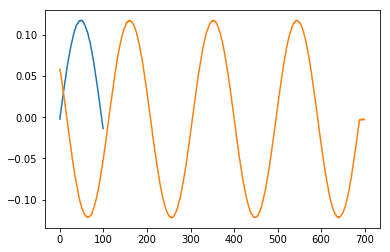

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(raw_volt[:100])
plt.plot(raw_volt[-700:])
plt.show()

In [9]:
len(raw_volt) / 4

5529600.0

In [7]:
del scanline
del raw
del tawg
del hardware_setup
card.reset()

In [8]:
import matplotlib.pyplot as plt
import numpy as np
raw_mean = np.mean(raw_volt)
raw_volt -= raw_mean 

In [66]:
import numpy as np
fourier = np.fft.rfft(raw_volt[:last:10])

In [67]:
ampl = np.abs(fourier)
#freq = np.fft.fftfreq(len(ampl), 1e-8)

#ixd = np.argsort(freq)
#ampl = ampl[ixd]
#freq = freq[ixd]

In [71]:
freq = np.linspace(0, 1e7/2, num=len(ampl))

In [72]:
max_freq = freq[np.argmax(ampl)]
max_freq * 1920e-9

1.0000009722242476

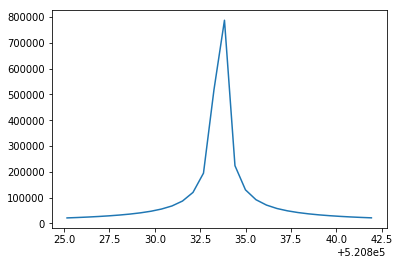

520833.610052


In [76]:
max_index = np.argmax(ampl)

sel = slice(max_index-15, max_index+15, 1)
plt.plot(freq[sel], ampl[sel])
plt.show()

max_freq_mean = np.sum(ampl[sel]*freq[sel]) / np.sum(ampl[sel])

print(max_freq_mean, max_freq)



In [65]:
volt_l = np.flatnonzero(raw_volt > 0.05)
print(volt_l[-1], len(raw_volt))
#raw_volt = raw_volt[:volt_l[-1]]

plt.plot(raw_volt[volt_l[-1]+108:volt_l[-1]+120])
last = volt_l[-1] + 109

(volt_l[-1] + 109) / len(raw_volt)

172799530 172800000


0.99999791087962964

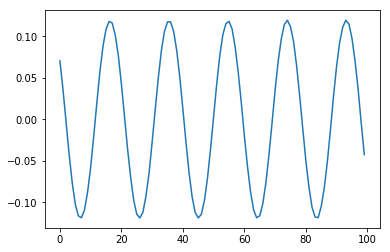

890998

In [52]:
a = raw_volt[:volt_l[-1] + 100:10]

plt.plot(a[:100])
plt.show()

np.sum(np.logical_and(a[:-2] < a[1:-1], a[1:-1] > a[2:]))

{'center': 520833.652549753, 'amplitude': 1226284.1411607806, 'sigma': 0.4398059725482273, 'c': 31488.238344030437}


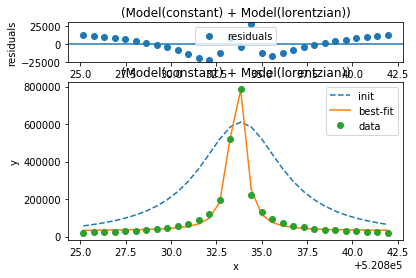

In [93]:
from lmfit import minimize, Parameters
from lmfit.models import LinearModel, LorentzianModel, ConstantModel

x = freq[sel]
y = ampl[sel]

lor = LorentzianModel()
model = ConstantModel() + LorentzianModel()

pars = lor.guess(y, x=x)
pars.add('c', 0)
out  = model.fit(y, pars, x=x)
out.best_values
print(out.best_values)
out.plot()

In [104]:
print(((out.best_values['center']+freq[1]) * 1920e-9 - 1) * 890998,
     ((out.best_values['center']-freq[1]) * 1920e-9 - 1) * 890998)


1.53608852786 -0.443911152704


In [5]:
import atsaverage.alazar
atsaverage.alazar.TriggerRangeID.et